## Analyse GTSR-gegevens

This notebook reads the output of a storm surge reanalysis with the global tidal shelf model (GTSM) for the Dutch coast. The model output consists of both storm surge and tidal data. The time series shall be used as an independent variable in the sea level regression. 

In Dutch: 
In dit notebook lezen we de met een globaal model herberekende windopzet langs de Nederlandse kust in. Deze tijdreeks gebruiken we vervolgens als verklarende variabele in een regressie van de zeewaterstanden langs de kust.

Bepaal de windopzet- en eventueel getij-gegevens op basis van een globaal model.

In [1]:
from netCDF4 import Dataset
# coordinate systems
import pyproj 

# plotting
import bokeh.io
import bokeh.plotting
import bokeh.tile_providers
import bokeh.palettes

import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt

# Some coordinate systems
WEBMERCATOR = pyproj.Proj(init='epsg:3857')
WGS84 = pyproj.Proj(init='epsg:4326')

# If this notebook is not showing up with figures, you can use the following url:
# https://nbviewer.ipython.org/github/openearth/notebooks/blob/master/sealevelmonitor.ipynb
bokeh.io.output_notebook()
# we're using matplotlib for polar plots (non-interactive)
%matplotlib inline
# does not work properly
# %matplotlib notebook


Loading BokehJS ...

Define the two datasets for surge and tide:

In [2]:
ds = {
    'tide': Dataset('d:/Documents/2695.50 Zeespiegelstijging 2018/Data/FES2012_tide_NorthSea_zeespiegelmonitor.nc', 'r'),
    'surge': Dataset('d:/Documents/2695.50 Zeespiegelstijging 2018/Data/GTSR_surge_NorthSea_zeespiegelmonitor.nc', 'r')
}

In [32]:
ds['tide'].variables['time']

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    axis: T
    units: Minutes since 1979-01-01 00:00:00 0:00
    long_name: time
    comment: 
    ancillary_variables: 
    _FillValue: nan
    calendar: gregorian
    standard_name: time
unlimited dimensions: 
current shape = (1893456,)
filling off

The data sets (not similar) contain the following data:

In [9]:
list(ds['tide'].variables.keys())

['tide',
 'time',
 'station_name',
 'station_id',
 'station_available',
 'station_y_coordinate',
 'station_x_coordinate',
 'crs']

Get some data such as names and coordinates from both data sets.

In [10]:
# Derive station names
station_names = []
for station in ds['tide'].variables['station_name'][:]:#.data.T:
    station_names.append(''.join([s.decode() for s in station]))

In [11]:
# Get coordinates
coordinates = {}
for quantity in ['tide', 'surge']:
    coordinates[quantity] = np.vstack([
        ds[quantity].variables['station_x_coordinate'][:].data,
        ds[quantity].variables['station_y_coordinate'][:].data
    ]).T


To get an overview of the tide station locations in relation to the model output locations, we plot both:

In [12]:
# show all the stations on a map

# compute the bounds of the plot
sw = (51, 3)
ne = (54, 6)
# transform to web mercator
sw_wm = pyproj.transform(WGS84, WEBMERCATOR, sw[1], sw[0])
ne_wm = pyproj.transform(WGS84, WEBMERCATOR, ne[1], ne[0])
# create a plot
fig = bokeh.plotting.figure(tools='pan, wheel_zoom', plot_width=600, plot_height=600, x_range=(sw_wm[0], ne_wm[0]), y_range=(sw_wm[1], ne_wm[1]))
fig.axis.visible = False
# add some background tiles
fig.add_tile(bokeh.tile_providers.STAMEN_TERRAIN)
# add the stations
x, y = pyproj.transform(WGS84, WEBMERCATOR, np.array(coordinates['tide'][:, 0]), np.array(coordinates['tide'][:, 1]))
fig.circle(x, y);

In [13]:
# Add tide stations
tide_stations = [
    [51.442222, 3.596111, 'VLISSINGEN'],
    [51.977500, 4.120000, 'HOEK VAN HOLLAND'],
    [52.964444, 4.745000, 'DEN HELDER'],
    [53.326389, 6.933056, 'DELFZIJL'],
    [53.175556, 5.409444, 'HARLINGEN'],
    [52.462222, 4.554722, 'IJMUIDEN']
]

tide_coords = np.array([station[:2] for station in tide_stations])
st_x, st_y = pyproj.transform(WGS84, WEBMERCATOR, np.array(tide_coords)[:, 1], np.array(tide_coords)[:, 0])
fig.circle(st_x, st_y, color='red', size=7, alpha=0.3);


In [14]:
# show the plot
bokeh.io.show(fig)

For most stations there is a nearby model output location, which we will assume representative. Only for Delfzijl there is no nearby location. We will still use the nearest location, but keep in mind that this might give unrepresentative data.

In [18]:
# find nearest (roughly) station and get data
def find_station_index(model_crds, tide_stations):
    index = [np.hypot(coordinates[quantity][:, 0] - station[1], coordinates[quantity][:, 1] - station[0]).argmin()
             for station in tide_stations]
    return index

# Get tide data
data = ds['tide'].variables['tide'][:, find_station_index(coordinates['tide'], tide_stations)]
values = data.data
values[values > 1000.0] = np.nan
values[~data.mask] = np.nan

# Create time series
start_date = datetime.datetime.strptime(ds['tide']['time'].units.split()[2], '%Y-%m-%d')
time = start_date + np.array([datetime.timedelta(seconds=minutes) for minutes in ds['tide'].variables['time'][:] * 60])
print(time[0])
tide = pd.DataFrame(
    data=values,
    index=time,
    columns=[station[-1].lower().capitalize() for station in tide_stations]
)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


1979-01-01 00:00:00
1979-01-01 00:00:00


A data correction of one day is required to get the right storm surge data at the right moment.

In [ ]:
# Get values
data = ds['surge'].variables['waterlevel'][:, find_station_index(coordinates['surge'], tide_stations)]

# Construct time index
date_correction = datetime.timedelta(days=366)
time = [datetime.datetime.fromordinal(int(ts)) + datetime.timedelta(seconds=round((ts % 1) * 86400)) - date_correction
        for ts in ds['surge']['time'][:]]
print(time[0])
surge = pd.DataFrame(
    data=data,
    index=time,
    columns=[station[-1].lower().capitalize() for station in tide_stations]
)

In [21]:
tide.head()

,Vlissingen,Hoek van holland,Den helder,Delfzijl,Harlingen,Ijmuiden
1979-01-01 00:00:00,0.285,-0.809,-0.664,1.436,-0.071,-0.912
1979-01-01 00:10:00,0.499,-0.787,-0.712,1.372,-0.107,-0.935
1979-01-01 00:20:00,0.716,-0.745,-0.764,1.295,-0.139,-0.944
1979-01-01 00:30:00,0.930,-0.681,-0.820,1.206,-0.170,-0.935
1979-01-01 00:40:00,1.137,-0.595,-0.876,1.109,-0.202,-0.909


In [22]:
surge.head()

,Vlissingen,Hoek van holland,Den helder,Delfzijl,Harlingen,Ijmuiden
1979-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1979-01-01 00:10:00,-0.000249,0.000590,0.000806,-0.003677,-0.002944,-0.000753
1979-01-01 00:20:00,-0.000890,0.001760,0.003596,-0.011441,-0.005254,-0.002288
1979-01-01 00:30:00,-0.001303,0.002308,0.007541,-0.016545,-0.004505,-0.003557
1979-01-01 00:40:00,-0.001141,0.001128,0.010611,-0.014177,-0.005693,-0.004845


In [23]:
surge.mean()

Vlissingen         -0.030393
Hoek van holland   -0.015394
Den helder          0.003117
Delfzijl            0.026735
Harlingen           0.014591
Ijmuiden           -0.004340
dtype: float64

Let us plot the tide and surge for one of the stations during over a period of one month.

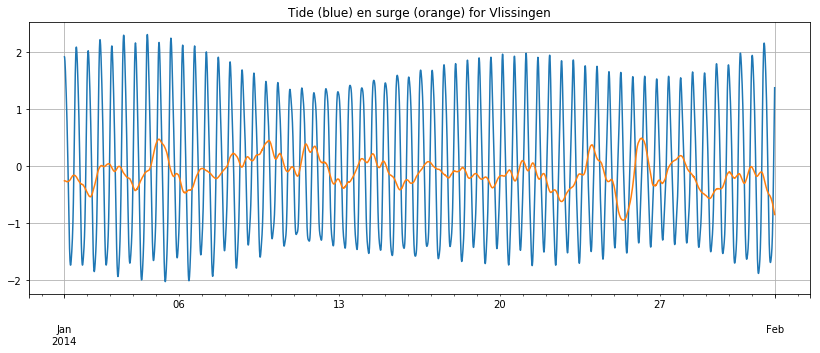

In [24]:
fig, ax = plt.subplots(figsize=(14, 5))
station = 'Vlissingen'
st_tide = tide.loc[datetime.datetime(2014, 1, 1):datetime.datetime(2014, 2, 1), station]
st_surge = surge.loc[datetime.datetime(2014, 1, 1):datetime.datetime(2014, 2, 1), station]

st_tide.plot(ax=ax)
st_surge.plot(ax=ax)
ax.grid()

ax.set_title(f'Tide (blue) en surge (orange) for {station}');

The figure below shows the spread of the surge at the stations.

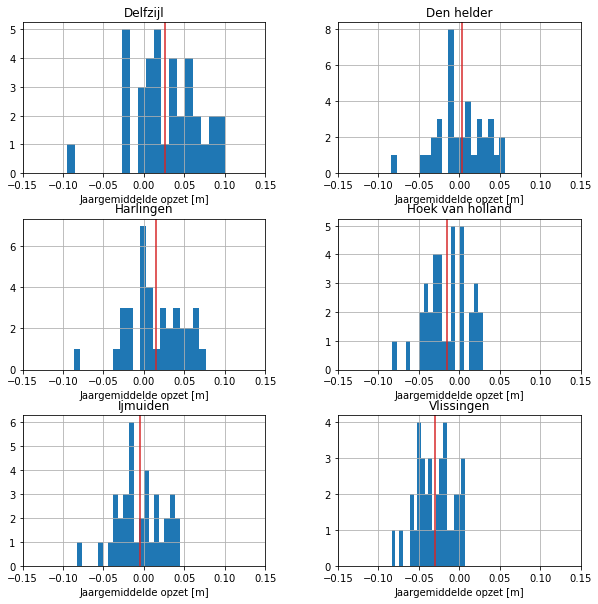

In [25]:
axs = surge.groupby(surge.index.year).mean().hist(figsize=(10, 10), bins=20)
for mean, ax in zip(surge.mean().sort_index().values, axs.ravel()):
    ax.set_xlim(-.15, .15)
    ax.set_xlabel('Jaargemiddelde opzet [m]')
    ax.set_ylim(ax.get_ylim())
    ax.plot([mean]*2, ax.get_ylim(), color='C3')

It is noteworthy that the spread over the different years is only a few centimeters.

Finally let us save the data as pickle to be loaded in a different notebook.

In [27]:
surge.to_pickle('d:/Documents/2695.50 Zeespiegelstijging 2018/Data/surge.pkl')